In [9]:
# import
using StructuralIdentifiability
using AbstractAlgebra
using DifferentialEquations
using SymPy
using Groebner

In [2]:
three_compartments = @ODEmodel(
    x1'(t) = - (k01 + k21 + k31)* x1(t) + k12 * x2(t) + u(t),
    x2'(t) = k21 * x1(t) - (k12 + k32) * x2(t) + k23 * x3(t),
    x3'(t) = k31 * x1(t) + k32 * x2(t) - (k23 + k03) * x3(t),
    y1(t) = x2(t),
    y2(t) = x3(t)
)

[ Info: Summary of the model:
[ Info: State variables: x1, x2, x3
[ Info: Parameters: k01, k31, k21, k32, k12, k23, k03
[ Info: Inputs: u
[ Info: Outputs: y1, y2


x1'(t) = -k01*x1(t) - k31*x1(t) - k21*x1(t) + k12*x2(t) + u(t)
x2'(t) = k21*x1(t) - k32*x2(t) - k12*x2(t) + k23*x3(t)
x3'(t) = k31*x1(t) + k32*x2(t) - k23*x3(t) - x3(t)*k03
y1(t) = x2(t)
y2(t) = x3(t)


In [3]:
assess_identifiability(three_compartments)

[ Info: Assessing local identifiability
[ Info: Local identifiability assessed in 0.0772504 seconds
[ Info: Assessing global identifiability
[ Info: Functions to check involve states
[ Info: Computing IO-equations
┌ Info: Computed in 2.5913322 seconds
│   :ioeq_time = :ioeq_time
└   ioeq_time = 2.5913322
[ Info: Computing Wronskians
┌ Info: Computed in 0.3742825 seconds
│   :wrnsk_time = :wrnsk_time
└   wrnsk_time = 0.3742825
[ Info: Dimensions of the Wronskians [4, 5]
┌ Info: Ranks of the Wronskians computed in 2.7e-5 seconds
│   :rank_time = :rank_time
└   rank_times = 2.7e-5
[ Info: Simplifying identifiable functions
✓ # Computing specializations..     Time: 0:00:01
┌ Info: Computing normal forms (probabilistic)
│ Variables (7 in total): Nemo.QQMPolyRingElem[k01, k31, k21, k32, k12, k23, k03]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 13
[ Info: Computing 8 Groebner bases for block orderings. Simplification code is 1
✓ #

Dict{Any, Symbol} with 10 entries:
  x3  => :globally
  k01 => :locally
  k32 => :locally
  k03 => :locally
  k23 => :locally
  k21 => :globally
  k12 => :locally
  k31 => :globally
  x1  => :locally
  x2  => :globally

Apart from the outputs (x2, x3), k21 and k31 are globalliy identifiable, while the others parameters and x1 are locally identifiable. Let's see which are the invariants.

In [120]:
id_funct = find_identifiable_functions(three_compartments)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lgand\.julia\packages\ProgressMeter\vnCY0\src\ProgressMeter.jl:626
✓ # Computing specializations..    Time: 0:00:00
┌ Info: Computing normal forms (probabilistic)
│ Variables (7 in total): Nemo.QQMPolyRingElem[k01, k31, k21, k32, k12, k23, k03]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 13
[ Info: Computing 8 Groebner bases for block orderings. Simplification code is 1
┌ Info: Final cleaning and simplification of generators. 
└ Out of 76 fractions 30 are syntactically unique.
[ Info: Checking inclusion with probability 0.995
[ Info: Inclusion checked in 0.0050912 seconds. Result: true
[ I

7-element Vector{AbstractAlgebra.Generic.Frac{Nemo.QQMPolyRingElem}}:
 k21
 k31
 k31*k23 + k21*k23 + k21*k03
 k31*k32 + k31*k12 + k21*k32
 k01 + k32 + k12 + k23 + k03
 k01*k32 + k01*k12 + k01*k23 + k01*k03 + k31*k03 + k32*k03 + k12*k23 + k12*k03
 (k01*k31^2*k32 + k01*k31*k21*k32 - k31^2*k32^2 - k31^2*k32*k12 - 2*k31*k21*k32^2 - k31*k21*k32*k12 - k21^2*k32^2)//(k31^2*k21 - k31^2*k23 + k31*k21^2 + k31*k21*k32 + k31*k21*k12 - k31*k21*k23 - k31*k21*k03 + k21^2*k32)

In [122]:
function create_system_of_equations(id_funct, names_map)
    id_funct_num_sympy = []
    id_funct_den_sympy = []
    for el in id_funct
        num = numerator(el)
        den = denominator(el)
        push!(id_funct_num_sympy, sympify(string(num)))
        push!(id_funct_den_sympy, sympify(string(den)))
    end
    
    id_funct_num_sympy_transf = copy(id_funct_num_sympy)
    id_funct_den_sympy_transf = copy(id_funct_den_sympy)
    
    for j in 1:length(id_funct_num_sympy_transf)
        id_funct_num_sympy_transf[j] = id_funct_num_sympy_transf[j].subs(names_map)
    end
    for j in 1:length(id_funct_den_sympy_transf)
            id_funct_den_sympy_transf[j] = id_funct_den_sympy_transf[j].subs(names_map)
    end
    
    lhs = id_funct_num_sympy .* id_funct_den_sympy_transf
    rhs = id_funct_num_sympy_transf .* id_funct_den_sympy
    system = lhs - rhs
    return system
    
end

create_system_of_equations (generic function with 1 method)

In [8]:
x1, x2, x3, k01, k03, k12, k21, k23, k31, k32, u, y1, y2, y3, w01, w03, w12, w21, w23, w31, w32 = SymPy.symbols("x1 x2 x3 k01 k03 k12 k21 k23 k31 k32 u y1 y2 y3 w01 w03 w12 w21 w23 w31 w32")
system = create_system_of_equations(id_funct, [(k01, w01), (k03, w03), (k12, w12), (k21, w21), (k23, w23), (k31, w31), (k32, w32)])

7-element Vector{Sym}:
                                                                                                                                                                                                                                                                                                                                                                                                                                               k21 - w21
                                                                                                                                                                                                                                                                                                                                                                                                                                               k31 - w31
                                                                                               

solving this --> orrible even for a subsystem [1:6], too long for the whole system



# Numerical solver

In [57]:
@vars x y

(x, y)

In [62]:
cos(x).subs(x,3)

cos(3)

In [76]:
function create_system_of_equations_num(id_funct, names, values)
    id_funct_num_sympy = []
    id_funct_den_sympy = []
    for el in id_funct
        num = numerator(el)
        den = denominator(el)
        push!(id_funct_num_sympy, sympify(string(num)))
        push!(id_funct_den_sympy, sympify(string(den)))
    end
    
    id_funct_num_sympy_transf = copy(id_funct_num_sympy)
    id_funct_den_sympy_transf = copy(id_funct_den_sympy)
    
    map = [(names[i], values[i]) for i in 1:length(names)]
    
    for j in 1:length(id_funct_num_sympy_transf)
        id_funct_num_sympy_transf[j] = id_funct_num_sympy_transf[j].subs(map)
    end
    for j in 1:length(id_funct_den_sympy_transf)
            id_funct_den_sympy_transf[j] = id_funct_den_sympy_transf[j].subs(map)
    end
    
    lhs = id_funct_num_sympy .* id_funct_den_sympy_transf
    rhs = id_funct_num_sympy_transf .* id_funct_den_sympy
    system = lhs - rhs
    return system
    
end

create_system_of_equations_num (generic function with 2 methods)

In [134]:
function find_numerical_transformations(model, names, with_states = false)
    id_funct = find_identifiable_functions(model , with_states = with_states)
    for var in names
        @vars eval(names_map[1])
    end
    @vars u
    values = rand(Float64, length(names))
    println(values)
    system = create_system_of_equations_num(id_funct,names, values) 
    println(system)
    println(names)
    SymPy.solve(system)
end

find_numerical_transformations (generic function with 2 methods)

In [68]:
names = [el[1] for el in names_map]

9-element Vector{String}:
 "N"
 "S"
 "Tr"
 "Inf"
 "a"
 "b"
 "g"
 "d"
 "nu"

In [140]:
sol_treat = find_numerical_transformations(Treatment, names)

[ Info: Computing IO-equations
┌ Info: Computed in 0.0263125 seconds
│   :ioeq_time = :ioeq_time
└   ioeq_time = 0.0263125
[ Info: Computing Wronskians
┌ Info: Computed in 0.0036401 seconds
│   :wrnsk_time = :wrnsk_time
└   wrnsk_time = 0.0036401
[ Info: Dimensions of the Wronskians [10, 1]
┌ Info: Ranks of the Wronskians computed in 2.06e-5 seconds
│   :rank_time = :rank_time
└   rank_times = 2.06e-5
[ Info: Simplifying identifiable functions
┌ Info: Computing normal forms (probabilistic)
│ Variables (5 in total): Nemo.QQMPolyRingElem[b, nu, d, g, a]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 5


[0.48921709101149147, 0.9526343898354503, 0.4827709536731203, 0.7335454221538555, 0.8319194663207132, 0.1602513944604106, 0.0018927069575939148, 0.1805662215199011, 0.7112248163118752]
Sym[d*g + nu - 0.711566575255652, a*nu + g*nu - 0.593027909778469, a + g + nu - 1.54503698959018, -0.00189270695759391*b + 0.160251394460411*g]
["N", "S", "Tr", "Inf", "a", "b", "g", "d", "nu"]


[ Info: Computing 6 Groebner bases for block orderings. Simplification code is 1
┌ Info: Final cleaning and simplification of generators. 
└ Out of 48 fractions 10 are syntactically unique.
[ Info: Checking inclusion with probability 0.995
[ Info: Inclusion checked in 0.0066689 seconds. Result: true
[ Info: Out of 12 initial generators there are 4 indepdendent
[ Info: The ranking of the new set of generators is 62
[ Info: The search for identifiable functions concluded in 0.263244 seconds


2-element Vector{Dict{Any, Any}}:
 Dict(a => 0.711224816311885 - g, b => 84.6678318677126*g, d => -0.122245598022643/g, nu => 0.833812173278295)
 Dict(a => 0.833812173278295 - g, b => 84.6678318677126*g, d => 0.000341758943766906/g, nu => 0.711224816311885)

In [130]:
@vars a b d nu g

(a, b, d, nu, g)

In [136]:
sol_treat[2][a]

0.833812173278295 - g

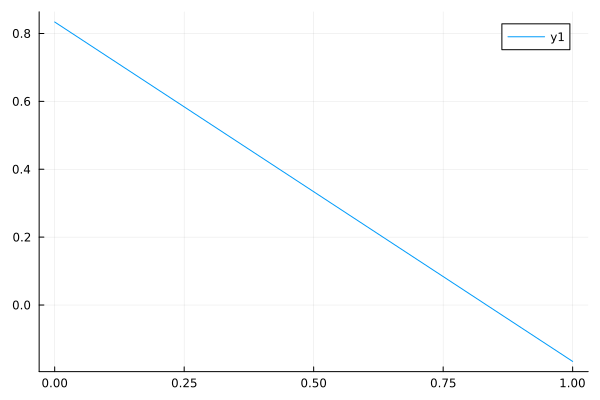

In [133]:
using Plots
plot(sol_treat[2][a], 0,1)

In [141]:
sol_3 = find_numerical_transformations(three_compartments, [k01, k03, k12, k21, k23, k31, k32])

[ Info: Computing IO-equations
┌ Info: Computed in 0.0198463 seconds
│   :ioeq_time = :ioeq_time
└   ioeq_time = 0.0198463
[ Info: Computing Wronskians
┌ Info: Computed in 0.0028491 seconds
│   :wrnsk_time = :wrnsk_time
└   wrnsk_time = 0.0028491
[ Info: Dimensions of the Wronskians [4, 5]
┌ Info: Ranks of the Wronskians computed in 2.51e-5 seconds
│   :rank_time = :rank_time
└   rank_times = 2.51e-5
[ Info: Simplifying identifiable functions
┌ Info: Computing normal forms (probabilistic)
│ Variables (7 in total): Nemo.QQMPolyRingElem[k01, k31, k21, k32, k12, k23, k03]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 13


[0.7291197308204026, 0.11490695503671267, 0.07332722784870027, 0.06899843164021469, 0.960149793230096, 0.5237182156250012, 0.2730815550931974]


[ Info: Computing 8 Groebner bases for block orderings. Simplification code is 1
┌ Info: Final cleaning and simplification of generators. 
└ Out of 76 fractions 30 are syntactically unique.
[ Info: Checking inclusion with probability 0.995
[ Info: Inclusion checked in 0.0069906 seconds. Result: true
[ Info: Out of 7 initial generators there are 7 indepdendent
[ Info: The ranking of the new set of generators is 373398
[ Info: The search for identifiable functions concluded in 1.2864465 seconds


Sym[k21 - 0.0689984316402147, k31 - 0.523718215625001, k03*k21 + k21*k23 + k23*k31 - 0.577025165997819, k12*k31 + k21*k32 + k31*k32 - 0.200262788690461, k01 + k03 + k12 + k23 + k32 - 2.15058526202911, k01*k03 + k01*k12 + k01*k23 + k01*k32 + k03*k12 + k03*k31 + k03*k32 + k12*k23 - 1.20680733204299, -0.266962519979812*k01*k21*k31*k32 - 0.266962519979812*k01*k31^2*k32 + 0.0293922346877531*k03*k21*k31 + 0.266962519979812*k12*k21*k31*k32 - 0.0293922346877531*k12*k21*k31 + 0.266962519979812*k12*k31^2*k32 - 0.0293922346877531*k21^2*k31 + 0.266962519979812*k21^2*k32^2 - 0.0293922346877531*k21^2*k32 + 0.0293922346877531*k21*k23*k31 - 0.0293922346877531*k21*k31^2 + 0.533925039959624*k21*k31*k32^2 - 0.0293922346877531*k21*k31*k32 + 0.0293922346877531*k23*k31^2 + 0.266962519979812*k31^2*k32^2]
Sym[k01, k03, k12, k21, k23, k31, k32]


3-element Vector{Dict{Any, Any}}:
 Dict(k12 => 0.603539345080458, k31 => 0.523718215625001, k03 => 0.985863235899987, k32 => -0.195408313076675 + 0.e-22*I, k01 => -0.102170357116438, k23 => 0.858761351241778 - 1.35525271560688e-20*I, k21 => 0.0689984316402147)
 Dict(k12 => 0.0733272278486918, k31 => 0.523718215625001, k03 => 0.114906955036723, k32 => 0.273081555093206 - 0.e-23*I, k01 => 0.729119730820394 + 2.71050543121376e-20*I, k23 => 0.960149793230096, k21 => 0.0689984316402147)
 Dict(k12 => 0.18702694539969 + 1.27054942088145e-21*I, k31 => 0.523718215625001, k03 => -0.128458709008008, k32 => 0.172617676665592 + 0.e-23*I, k01 => 0.930919241059938 - 2.71050543121376e-20*I, k23 => 0.988480107911897 - 2.71050543121376e-20*I, k21 => 0.0689984316402147)

In [142]:
sol_3[1]

Dict{Any, Any} with 7 entries:
  k12 => 0.603539345080458
  k31 => 0.523718215625001
  k03 => 0.985863235899987
  k32 => -0.195408313076675 + 0.e-22*I
  k01 => -0.102170357116438
  k23 => 0.858761351241778 - 1.35525271560688e-20*I
  k21 => 0.0689984316402147

In [154]:
function plot_numerical_transformation(model, names, k = 3, index_variable = 1, case = 1, with_states = false)
    id_funct = find_identifiable_functions(model , with_states = with_states)
    #for var in names
     #   @vars eval(names_map[1])
    #end
    #@vars u
    values = rand(Float64, length(names))*k
    println(values)
    data_x = []
    data_y = []
    for i in 1:5
        var_x = rand(Float64)*k
        values[index_variable] = var_x
        system = create_system_of_equations_num(id_funct,names, values) 
        var_y = SymPy.solve(system)[case][k01]
        push!(data_x, var_x)
        push!(data_y, var_y)
    end
    plot(data_x, data_y, seriestype=:scatter)
end

plot_numerical_transformation (generic function with 5 methods)

In [ ]:
plot_numerical_transformation(three_compartments, [k01, k03, k12, k21, k23, k31, k32])

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\lgand\.julia\packages\ProgressMeter\vnCY0\src\ProgressMeter.jl:626
✓ # Computing specializations..    Time: 0:00:00
┌ Info: Computing normal forms (probabilistic)
│ Variables (7 in total): Nemo.QQMPolyRingElem[k01, k31, k21, k32, k12, k23, k03]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 13
[ Info: Computing 8 Groebner bases for block orderings. Simplification code is 1


# General function

In [58]:
function find_transformations(model, names_map, with_states = false)
    id_funct = find_identifiable_functions(model , with_states = with_states)
    for var in names_map
        @vars names_map[1], names_map[2]
    end
    @vars u
    system = create_system_of_equations(id_funct, names_map) 
    unknown = [var[2] for var in names_map]
    SymPy.solve(system, unknown)
end

find_transformations (generic function with 2 methods)

In [15]:
Treatment = @ODEmodel(
	S'(t) = (-b*Inf(t)*S(t) - b*S(t)*d*Tr(t))//N(t),
	Inf'(t) = (b*Inf(t)*S(t) + b*S(t)*d*Tr(t) - Inf(t)*N(t)*g - Inf(t)*N(t)*a)//N(t),
	Tr'(t) = Inf(t)*g - nu*Tr(t),
	N'(t) = 0,
	y1(t) = Tr(t),
	y2(t) = N(t)
)

[ Info: Summary of the model:
[ Info: State variables: S, Inf, Tr, N
[ Info: Parameters: b, nu, d, g, a
[ Info: Inputs: 
[ Info: Outputs: y1, y2


S'(t) = (-b*S(t)*Inf(t) - b*S(t)*d*Tr(t))//N(t)
Inf'(t) = (b*S(t)*Inf(t) + b*S(t)*d*Tr(t) - Inf(t)*N(t)*g - Inf(t)*N(t)*a)//N(t)
Tr'(t) = -nu*Tr(t) + Inf(t)*g
N'(t) = 0
y1(t) = Tr(t)
y2(t) = N(t)


In [17]:
names_map = [("N", "N2"), ("S", "S2"), ("Tr", "Tr2"), ("Inf", "Inf2"), ("a", "a2"), ("b","b2"), ("g", "g2"), ("d", "d2"), ("nu", "nu2")]

9-element Vector{Tuple{String, String}}:
 ("N", "N2")
 ("S", "S2")
 ("Tr", "Tr2")
 ("Inf", "Inf2")
 ("a", "a2")
 ("b", "b2")
 ("g", "g2")
 ("d", "d2")
 ("nu", "nu2")

In [60]:
#to fix with_states = true
find_transformations(Treatment, names_map)

[ Info: Computing IO-equations
┌ Info: Computed in 0.0409943 seconds
│   :ioeq_time = :ioeq_time
└   ioeq_time = 0.0409943
[ Info: Computing Wronskians
┌ Info: Computed in 0.0113607 seconds
│   :wrnsk_time = :wrnsk_time
└   wrnsk_time = 0.0113607
[ Info: Dimensions of the Wronskians [10, 1]
┌ Info: Ranks of the Wronskians computed in 4.46e-5 seconds
│   :rank_time = :rank_time
└   rank_times = 4.46e-5
[ Info: Simplifying identifiable functions
┌ Info: Computing normal forms (probabilistic)
│ Variables (5 in total): Nemo.QQMPolyRingElem[b, nu, d, g, a]
│ Up to degree: 2
└ Modulo: Finite field of characteristic 1073741827
[ Info: Used specialization points: 5
[ Info: Computing 6 Groebner bases for block orderings. Simplification code is 1


nu + d*g
1
nu*g + nu*a
1
nu + g + a
1
g
b


┌ Info: Final cleaning and simplification of generators. 
└ Out of 48 fractions 10 are syntactically unique.
[ Info: Checking inclusion with probability 0.995
[ Info: Inclusion checked in 0.0151426 seconds. Result: true
[ Info: Out of 12 initial generators there are 4 indepdendent
[ Info: The ranking of the new set of generators is 62
[ Info: The search for identifiable functions concluded in 0.7165483 seconds


2-element Vector{NTuple{9, Sym}}:
 (N2, S2, Tr2, Inf2, -g2 + nu, b*g2/g, g2, -(a - d*g + g - nu)/g2, a + g)
 (N2, S2, Tr2, Inf2, a + g - g2, b*g2/g, g2, d*g/g2, nu)